# Variational Autoencoder

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/abdenlab/bbs741/blob/master/03_autoencoders-vae.ipynb)

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import interact

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import mnist
from sklearn.decomposition import PCA

In [3]:
def plot_scatter(ax, x1, x2, labels, s=5, xlabel='z1', ylabel='z2'):
    ax.axhline(0, c='k', lw=0.5, ls='--')
    ax.axvline(0, c='k', lw=0.5, ls='--')
    h = ax.scatter(
        x1, 
        x2,
        c=labels, 
        s=s,
        edgecolor='none', 
        alpha=0.5,
        cmap=plt.cm.get_cmap('nipy_spectral', 10),
    )
    ax.set_aspect(1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar(h, ticks=np.arange(0, 10), values=np.arange(0, 10));

## Load MNIST digit data

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Convert uint8 grayscale pixels [0, 255] to floats in [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Flatten the 28 x 28 grayscale images
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## Build the model

In [5]:
original_dim = 28 * 28

intermediate_dim = 64

latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)

2022-11-10 10:41:55.932500: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We create two unconnected dense layers for the means and (log) standard deviations of the multivariate Normal distributions that each input point is mapped to.

In [6]:
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

We also create a custom function "layer" `z` that implements the random sampling of the multivariate normal distribution defined by `z_mean` and `z_log_sigma`.

In [7]:
import tensorflow.keras.backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(
        shape=(K.shape(z_mean)[0], latent_dim),
        mean=0., 
        stddev=0.1
    )
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

Then we pass the collection of mean parameter nodes, standard deviation nodes, and random sample nodes as the outputs of an encoder model.

In [8]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

Next, instantiate the decoder model and assemble the autoencoder.

In [9]:
# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

Finally, we build a custom loss function for the variational autoencoder. It is a sum of two parts, averaged over the inputs.

1. The **reconstruction loss** compares the input to the reconstructed output using binary cross-entropy. This makes sure our model captures information about our data.

2. The **KL loss** compares the parameters of the normal distribution we are training to a unit Normal distribution centered at the origin of latent space. The larger the difference, the greater the penalty.

In [10]:
reconstruction_loss = tf.keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim

kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)

Hook up the loss function, compile and train!

In [11]:
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

history = vae.fit(
    x_train, x_train,
    epochs=100,
    batch_size=32,
    validation_data=(x_test, x_test)
)

Epoch 1/100
1875/1875 [==============================] - 3s 1ms/step - loss: 187.2107 - val_loss: 168.4345
Epoch 2/100
1875/1875 [==============================] - 3s 1ms/step - loss: 165.8306 - val_loss: 163.5760
Epoch 3/100
1875/1875 [==============================] - 3s 1ms/step - loss: 162.2765 - val_loss: 161.0996
Epoch 4/100
1875/1875 [==============================] - 3s 1ms/step - loss: 159.9498 - val_loss: 159.0646
Epoch 5/100
1875/1875 [==============================] - 3s 1ms/step - loss: 158.1730 - val_loss: 157.4846
Epoch 6/100
1875/1875 [==============================] - 3s 1ms/step - loss: 156.6748 - val_loss: 156.1826
Epoch 7/100
1875/1875 [==============================] - 3s 1ms/step - loss: 155.3808 - val_loss: 155.0107
Epoch 8/100
1875/1875 [==============================] - 3s 1ms/step - loss: 154.3079 - val_loss: 154.0238
Epoch 9/100
1875/1875 [==============================] - 3s 1ms/step - loss: 153.4760 - val_loss: 153.2590
Epoch 10/100
1875/1875 [=============

Now, we'll run the test data through our encoder.

It will generate estimates for the parameters of the latent Gaussians (means and stdevs) for the inputs we feed it as well as a random sample from that distribution. For simplicity, we'll just plot the means in the scatter plot below.

In [12]:
# Encode the test data
mu, log_sigma, z = encoder.predict(x_test, batch_size=256, verbose=0)

We'll also uniformly sample our latent space along a grid around the origin and generate digit images using our decoder.

In [13]:
# Make a diagram with 15x15 digits, sampling points from a grid in latent space
lo, hi = -4, 4
n = 15
digit_size = 28
heatmap = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(lo, hi, n)
grid_y = np.linspace(lo, hi, n)
for i, yi in enumerate(grid_y[::-1]):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample, verbose=0)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        
        heatmap[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit

Notice the smooth interpolation of synthetic digits throughout the latent space and its correspondence to the locations of the test data on the left.

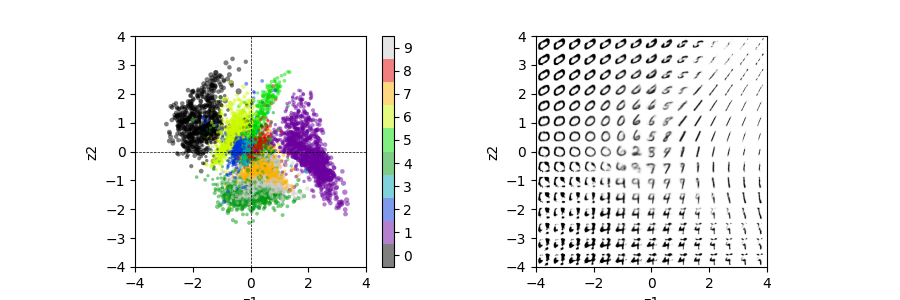

In [14]:
plt.figure(figsize=(9, 3))
gs = plt.GridSpec(nrows=1, ncols=2)

ax = ax0 = plt.subplot(gs[0])
plot_scatter(ax, mu[:, 0], mu[:, 1], s=np.mean(np.exp(log_sigma), axis=1) * 20, labels=y_test)
plt.xlim(lo, hi)
plt.ylim(lo, hi)

ax = plt.subplot(gs[1], sharex=ax0, sharey=ax0)
ax.imshow(heatmap, extent=[lo, hi, lo, hi], cmap='Greys')
plt.xlabel('z1')
plt.ylabel('z2');